# Indonesia Covid-19 Vaccination Analysis Using ARIMA: A Time Series Analysis

## Install & Import Library

In [1]:
'''
Install library
'''

!pip install pmdarima

In [2]:
'''
Import library
'''

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima, ADFTest
from pmdarima.metrics import smape
from pmdarima.model_selection import train_test_split

## Data Preprocessing

In [3]:
'''
Read File
'''

excel_file = pd.ExcelFile('COVID-19 di Indonesia @kawalcovid19.xlsx')
excel_file.sheet_names

['Statistik Harian',
 'Grafik',
 'Sheet30',
 'Rapid Test',
 'Timeline per Provinsi',
 'Sheet26',
 'Detail1-50-59-Dalam Perawatan',
 'ASEAN',
 'Kasus per Provinsi',
 'Timeline',
 'Tabulasi Daerah',
 'Tingkat Kematian',
 'Score Card',
 'Daftar Kasus (baru)',
 'Tabel',
 'Italia',
 'Legenda',
 'Sheet35',
 'Daftar Meninggal',
 'Risk by Age - World',
 'Rangkuman',
 'Sheet23',
 'Kasus ekspor',
 'Kasus WNI di LN',
 'Kasus Transit',
 'Jurnal',
 'Korsel',
 'Copy of Data PCR - Kemenkes',
 'Daftar Kasus']

In [4]:
'''
Choose specific sheet
'''

df = excel_file.parse('Statistik Harian')
df

,Unnamed: 0,Kasus harian,Kasus Impor,Kasus Lokal,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),Tingkat kesembuhan (closed cases),Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),Tingkat kematian (closed cases),PDP,ODP,Suspek aktif,Jumlah spesimen diperiksa (dari 1 April),Jumlah orang diperiksa,Negatif,Positif \n(=C),Dalam Proses,Spesimen,Spesimen (PCR-TCM),Spesimen (Antigen),Orang yang dites,Orang yang dites (PCR-TCM),Orang yang dites (Antigen),Vaksinasi (ineligible),Jumlah test/juta penduduk,Test/Positif,Jumlah org yg dites / positif,Jumlah Test/Positif harian,Positif / Jumlah Tes,Positive rate harian,Case Growth Rate,Tingkat positivitas mingguan,Jumlah spesimen diperiksa (rata-rata 7 hari),Jumlah orang diperiksa (rata-rata 7 hari),...,Dosis ketiga,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis harian,Dosis pertama (mingguan),Dosis kedua (mingguan),Rata2 dosis harian (mingguan),Dosis pertama (SDM kesehatan),Dosis kedua (SDM kesehatan),Dosis ketiga (SDM kesehatan),Dosis pertama (SDM kesehatan) %,Dosis kedua (SDM kesehatan) %,Dosis pertama (petugas publik),Dosis kedua (petugas publik),Dosis pertama (petugas publik) %,Dosis kedua (petugas publik) %,Dosis pertama (lansia),Dosis kedua (lansia),Dosis pertama (lansia) %,Dosis kedua (lansia) %,Dosis pertama (warga umum),Dosis kedua (warga umum),Dosis pertama (remaja),Dosis kedua (remaja),Unnamed: 70,Test PCR Orang Nasional Rata-rata 7 hari,Pos Rate Nasional - rata-rata 7 hari,Test Orang DKI,Positif DKI,Unnamed: 75,Pos Rate DKI,Pos Rate DKI - 7 harian,NON DKI,Positif Non DKI,Unnamed: 80,Pos Rate Non DKI,Pos Rate Non DKI - 7 harian,CFR
0,2020-03-02,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,339.0,339.0,335.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.5,169.5,0,0.005900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,341.0,341.0,337.0,2.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,170.5,170.5,#DIV/0!,0.005865,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-04,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,372.0,372.0,356.0,2.0,14.0,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN,186.0,186.0,#DIV/0!,0.005376,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-05,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,388.0,388.0,371.0,2.0,15.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,194.0,194.0,#DIV/0!,0.005155,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-06,2.0,0.0,2.0,4.0,4.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,450.0,450.0,422.0,4.0,24.0,NaN,NaN,NaN,62.0,NaN,NaN,NaN,NaN,112.5,112.5,31,0.008889,0.0377358,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
'''
Change index
'''

df.index = df['Unnamed: 0']

In [6]:
'''
Choose specific column
'''
copied_df = df.copy()
copied_df = copied_df[['Dosis pertama', 'Dosis kedua']]
copied_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 2020-03-02 to NaT
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dosis pertama  219 non-null    float64
 1   Dosis kedua    205 non-null    float64
dtypes: float64(2)
memory usage: 13.2 KB


In [7]:
'''
Select first dose which is > 0
'''

df_final = copied_df[copied_df['Dosis pertama'] > 0]
df_final

,Dosis pertama,Dosis kedua
Unnamed: 0,,
2021-01-13,66.0,NaN
2021-01-14,7760.0,NaN
2021-01-15,18958.0,NaN
2021-01-16,24414.0,NaN
2021-01-17,24540.0,NaN
...,...,...
2021-08-15,53688122.0,28112285.0
2021-08-16,54028976.0,28609254.0
2021-08-17,54446247.0,28853053.0


In [8]:
'''
Fill empty data with 0 since second dose is started two weeks after the starting of first dose vaccination
'''

df_final = df_final.fillna(0)
df_final

,Dosis pertama,Dosis kedua
Unnamed: 0,,
2021-01-13,66.0,0.0
2021-01-14,7760.0,0.0
2021-01-15,18958.0,0.0
2021-01-16,24414.0,0.0
2021-01-17,24540.0,0.0
...,...,...
2021-08-15,53688122.0,28112285.0
2021-08-16,54028976.0,28609254.0
2021-08-17,54446247.0,28853053.0


## Exploratory Data Analysis

In [9]:
def visualize_line_chart(chart_title, chart_data, size=(8,4)):
  plt.figure(figsize=size)
  plt.title(chart_title)
  sns.lineplot(data=chart_data)
  plt.show()

In [10]:
df_final.describe()

,Dosis pertama,Dosis kedua
count,2.190000e+02,2.190000e+02
mean,1.731356e+07,8.572775e+06
std,1.648306e+07,7.642252e+06
min,6.600000e+01,0.000000e+00
25%,3.217526e+06,1.178102e+06
50%,1.246941e+07,7.703110e+06
75%,2.603062e+07,1.301332e+07
max,5.563723e+07,3.023023e+07


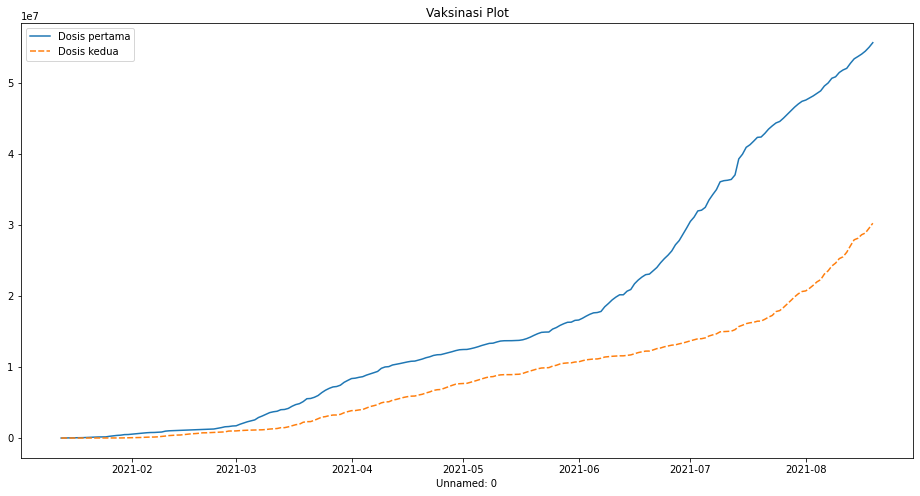

In [11]:
visualize_line_chart('Vaksinasi Plot', df_final, size=(16, 8))

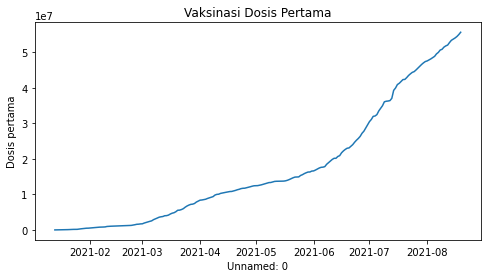

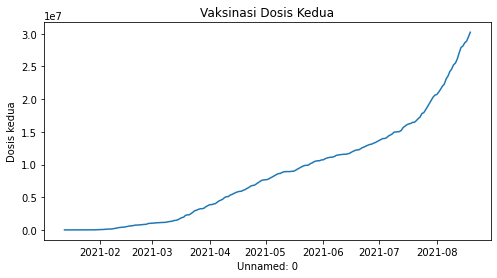

In [12]:
chart_dict = {
    'Dosis pertama': 'Vaksinasi Dosis Pertama',
    'Dosis kedua': 'Vaksinasi Dosis Kedua',
}

for (key, value) in chart_dict.items():
  visualize_line_chart(value, df_final[key], (8,4))
  print('')

## Data Splitting

In [13]:
df_dosis_1 = df_final[['Dosis pertama']]
df_dosis_2 = df_final[['Dosis kedua']]

In [14]:
train_split_len = int(0.8 * len(df_final))
train_split_len

175

In [15]:
train_dosis_1, test_dosis_1 = train_test_split(df_dosis_1, train_size=train_split_len)
train_dosis_2, test_dosis_2 = train_test_split(df_dosis_2, train_size=train_split_len)

print('Data Training 1st Dose of Vaccination Length: ', len(train_dosis_1))
print('Data Training 2nd Dose of Vaccination Length: ', len(train_dosis_2))
print('Data Test 1st Dose of Vaccination Length: ', len(test_dosis_1))
print('Data Test 2nd Dose of Vaccination Length: ', len(test_dosis_2))

Data Training 1st Dose of Vaccination Length:  175
Data Training 2nd Dose of Vaccination Length:  175
Data Test 1st Dose of Vaccination Length:  44
Data Test 2nd Dose of Vaccination Length:  44


In [16]:
print('---- Data Training 1st Dose of Vaccination ----')
print(train_dosis_1.head(3))
print('\n')

print('---- Data Training 2nd Dose of Vaccination ----')
print(train_dosis_2.head(3))
print('\n')

print('---- Data Test 1st Dose of Vaccination ----')
print(test_dosis_1.head(3))
print('\n')

print('---- Data Test 2nd Dose of Vaccination ----')
print(test_dosis_2.head(3))

---- Data Training 1st Dose of Vaccination ----
            Dosis pertama
Unnamed: 0               
2021-01-13           66.0
2021-01-14         7760.0
2021-01-15        18958.0


---- Data Training 2nd Dose of Vaccination ----
            Dosis kedua
Unnamed: 0             
2021-01-13          0.0
2021-01-14          0.0
2021-01-15          0.0


---- Data Test 1st Dose of Vaccination ----
            Dosis pertama
Unnamed: 0               
2021-07-07     34249444.0
2021-07-08     34959051.0
2021-07-09     36059414.0


---- Data Test 2nd Dose of Vaccination ----
            Dosis kedua
Unnamed: 0             
2021-07-07   14516938.0
2021-07-08   14659369.0
2021-07-09   14949729.0


## Build Model

In [17]:
def check_seasonality(data):
  decompose_result = seasonal_decompose(data, model='additive')
  decompose_figure = decompose_result.plot()
  decompose_figure = decompose_figure.set_size_inches(12,6)
  return decompose_figure

In [18]:
def should_difference_test(data):
  adf_test = ADFTest()
  test_result = adf_test.should_diff(data)
  return test_result

In [19]:
def create_prediction_df(prediction_model, num_periods, test_data, prediction_cols_name):
  df_prediction = pd.DataFrame(prediction_model.predict(n_periods=num_periods), index=test_data.index)
  df_prediction.columns = prediction_cols_name
  return df_prediction

In [20]:
def plot_actual_prediction_comparison(chart_title, training_data, testing_data, prediction_data, 
                                      training_label, testing_label, prediction_label):
  plt.figure(figsize=(12,6))
  plt.plot(training_data, label=training_label)
  plt.plot(testing_data, label=testing_label)
  plt.plot(prediction_data, label=prediction_label)
  plt.legend(loc='upper left')
  plt.title(chart_title)
  plt.show()

### 1st Dose of Vaccination

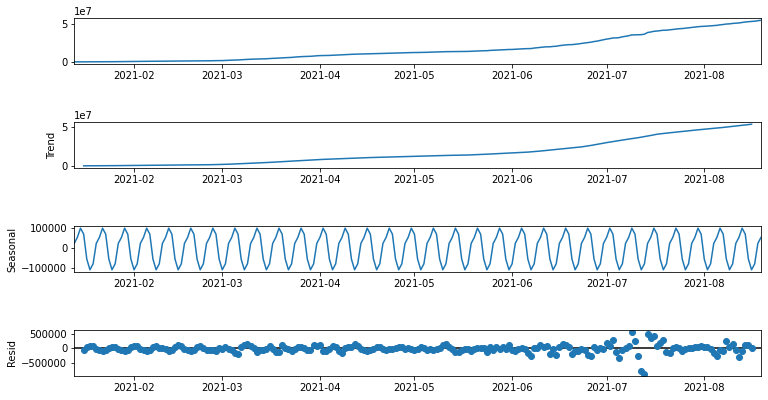

In [21]:
'''
Check seasonality
'''
check_seasonality(df_dosis_1)

In [22]:
'''
Check Difference
'''
should_difference_test(df_dosis_1)

(0.99, True)

In [23]:
'''
Build Model
'''
model_arima_1 = auto_arima(train_dosis_1, start_p=0, start_q=0, 
                           max_p=10, max_d=10, max_q=10, 
                           start_P=0, start_Q=0, 
                           max_P=10, max_D=10, max_Q=10, max_order=None,
                           m=52, seasonal=True, stationary=False, trace=True)

model_arima_1.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=4637.667, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[52]             : AIC=4611.409, Time=0.88 sec
 ARIMA(0,2,1)(0,0,1)[52]             : AIC=4583.664, Time=0.87 sec
 ARIMA(0,2,1)(0,0,0)[52]             : AIC=4581.705, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[52]             : AIC=4583.656, Time=0.85 sec
 ARIMA(0,2,1)(1,0,1)[52]             : AIC=inf, Time=2.86 sec
 ARIMA(1,2,1)(0,0,0)[52]             : AIC=4581.672, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[52]             : AIC=4583.671, Time=1.35 sec
 ARIMA(1,2,1)(0,0,1)[52]             : AIC=4583.671, Time=1.20 sec
 ARIMA(1,2,1)(1,0,1)[52]             : AIC=inf, Time=4.00 sec
 ARIMA(1,2,0)(0,0,0)[52]             : AIC=4609.439, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[52]             : AIC=4583.411, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[52]             : AIC=4582.033, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[52]             : AIC=4580.171, Time=0.05 sec
 ARIMA(0,2,2)(1,0,0)[52]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -2287.086
Date:                Sat, 21 Aug 2021   AIC                           4580.171
Time:                        08:09:08   BIC                           4589.631
Sample:                             0   HQIC                          4584.009
                                - 175                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6779      0.068     -9.983      0.000      -0.811      -0.545
ma.L2         -0.1032      0.068     -1.519      0.129      -0.236       0.030
sigma2      1.801e+10   2.88e-12   6.25e+21      0.000     1.8e+10     1.8e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               235.72
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              16.25   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.08e+36. Standard errors may be unstable.
"""

In [24]:
'''
Predict Test Data
'''
prediction_dosis_1 = create_prediction_df(model_arima_1, len(test_dosis_1),
                                          test_dosis_1, ['Predicted 1st Dose'])
prediction_dosis_1.head(3)

,Predicted 1st Dose
Unnamed: 0,
2021-07-07,3.420933e+07
2021-07-08,3.488165e+07
2021-07-09,3.555397e+07


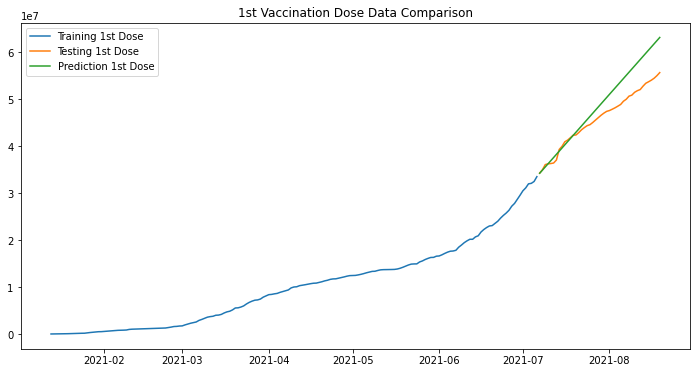

In [25]:
'''
Plot Forecasting
'''

plot_actual_prediction_comparison('1st Vaccination Dose Data Comparison', train_dosis_1, test_dosis_1, prediction_dosis_1,
                                  'Training 1st Dose', 'Testing 1st Dose', 'Prediction 1st Dose')

### 2nd Dose of Vaccination

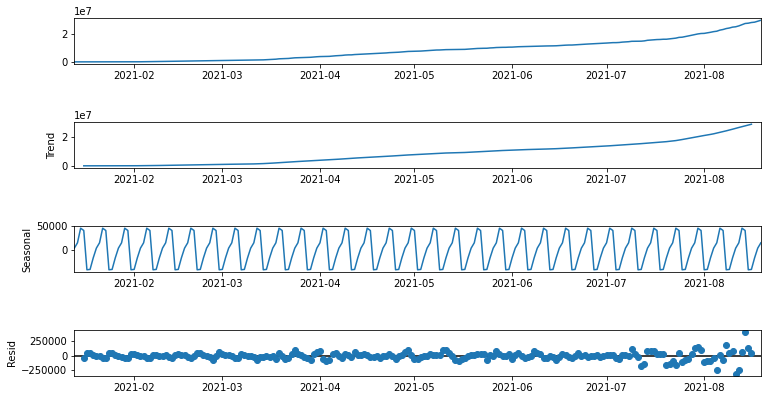

In [26]:
'''
Check seasonality
'''
check_seasonality(df_dosis_2)

In [27]:
'''
Check Difference
'''
should_difference_test(df_dosis_2)

(0.99, True)

In [28]:
'''
Build Model
'''
model_arima_2 = auto_arima(train_dosis_2, start_p=0, start_q=0, 
                           max_p=10, max_d=10, max_q=10, 
                           start_P=0, start_Q=0, 
                           max_P=10, max_D=10, max_Q=10, max_order=None,
                           m=52, seasonal=True, stationary=False, trace=True)

model_arima_2.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=4351.485, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[52]             : AIC=4334.356, Time=0.85 sec
 ARIMA(0,2,1)(0,0,1)[52]             : AIC=4298.214, Time=0.94 sec
 ARIMA(0,2,1)(0,0,0)[52]             : AIC=4296.673, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[52]             : AIC=4298.194, Time=1.00 sec
 ARIMA(0,2,1)(1,0,1)[52]             : AIC=4300.076, Time=2.38 sec
 ARIMA(1,2,1)(0,0,0)[52]             : AIC=4292.464, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[52]             : AIC=4294.456, Time=1.35 sec
 ARIMA(1,2,1)(0,0,1)[52]             : AIC=4294.456, Time=1.41 sec
 ARIMA(1,2,1)(1,0,1)[52]             : AIC=4296.455, Time=1.79 sec
 ARIMA(1,2,0)(0,0,0)[52]             : AIC=4332.846, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[52]             : AIC=4293.540, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[52]             : AIC=4291.983, Time=0.11 sec
 ARIMA(1,2,2)(1,0,0)[52]             : AIC=4293.969, Time=2.29 sec
 ARIMA(1,2,2)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -2142.004
Date:                Sat, 21 Aug 2021   AIC                           4290.009
Time:                        08:09:33   BIC                           4299.469
Sample:                             0   HQIC                          4293.847
                                - 175                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6614      0.077     -8.564      0.000      -0.813      -0.510
ma.L2         -0.2030      0.072     -2.817      0.005      -0.344      -0.062
sigma2      3.557e+09    1.4e-12   2.53e+21      0.000    3.56e+09    3.56e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.17
Prob(Q):                              0.89   Prob(JB):                         0.12
Heteroskedasticity (H):               7.45   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+38. Standard errors may be unstable.
"""

In [29]:
'''
Predict Test Data
'''
prediction_dosis_2 = create_prediction_df(model_arima_2, len(test_dosis_2), 
                                          test_dosis_2, ['Predicted 2nd Dose'])
prediction_dosis_2.head(3)

,Predicted 2nd Dose
Unnamed: 0,
2021-07-07,1.451702e+07
2021-07-08,1.464789e+07
2021-07-09,1.477876e+07


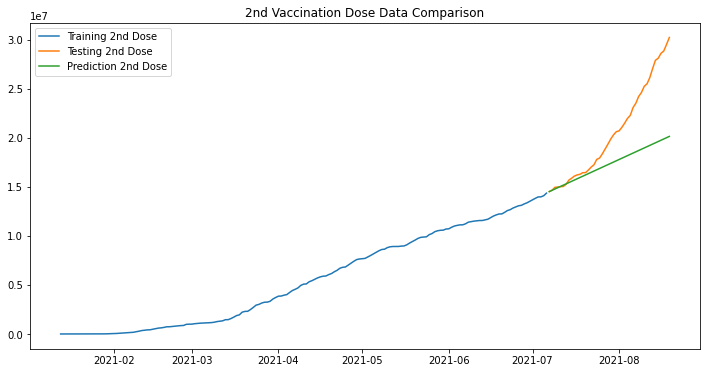

In [30]:
'''
Plot Forecasting
'''

plot_actual_prediction_comparison('2nd Vaccination Dose Data Comparison', train_dosis_2, test_dosis_2, prediction_dosis_2,
                                  'Training 2nd Dose', 'Testing 2nd Dose', 'Prediction 2nd Dose')

## Evaluate Model

In [31]:
def evaluate_model(y_actual, y_prediction):
  indicator_r2 = r2_score(y_actual, y_prediction)
  indicator_mae = mean_absolute_error(y_actual, y_prediction)
  indicator_mse = mean_squared_error(y_actual, y_prediction)
  indicator_rmse = indicator_mse ** 0.5
  indicator_smape = smape(y_actual, y_prediction)

  evaluation_dict = {
      'R2': [indicator_r2],
      'MAE': [indicator_mae],
      'MSE': [indicator_mse],
      'RMSE': [indicator_rmse],
      'SMAPE': [indicator_smape],
  }
  df_model_evaluation = pd.DataFrame(data=evaluation_dict)
  return df_model_evaluation

### 1st Dose of Vaccination

In [32]:
df_arima_1_evaluation = evaluate_model(test_dosis_1, prediction_dosis_1)
df_arima_1_evaluation

,R2,MAE,MSE,RMSE,SMAPE
0,0.564883,3.056083e+06,1.571142e+13,3.963763e+06,5.838209


### 2nd Dose of Vaccination

In [33]:
df_arima_2_evaluation = evaluate_model(test_dosis_2, prediction_dosis_2)
df_arima_2_evaluation

,R2,MAE,MSE,RMSE,SMAPE
0,0.122515,3.172247e+06,2.017173e+13,4.491295e+06,14.54504


## Forecast Data

In [34]:
def create_forecasting_df(starting_date, forecast_model, num_periods, forecast_cols_name):
  date_list = pd.date_range(starting_date, periods=num_periods).tolist()

  df_forecast = pd.DataFrame(forecast_model.predict(n_periods=num_periods), index=date_list)
  df_forecast.columns = forecast_cols_name
  return df_forecast

In [35]:
def plot_forecasting(chart_title, training_data, forecasting_data,  training_label, forecasting_label):
  plt.figure(figsize=(12,6))
  plt.plot(training_data, label=training_label)
  plt.plot(forecasting_data, label=forecasting_label)
  plt.legend(loc='upper left')
  plt.title(chart_title)
  plt.show()

### 1st Dose of Vaccination

In [36]:
vaksinasi_1_forecasting = create_forecasting_df(train_dosis_1.index[-1], model_arima_1, 
                                                365, ['forecast_vaksinasi_1'])
vaksinasi_1_forecasting.head(3)

,forecast_vaksinasi_1
2021-07-06,3.420933e+07
2021-07-07,3.488165e+07
2021-07-08,3.555397e+07


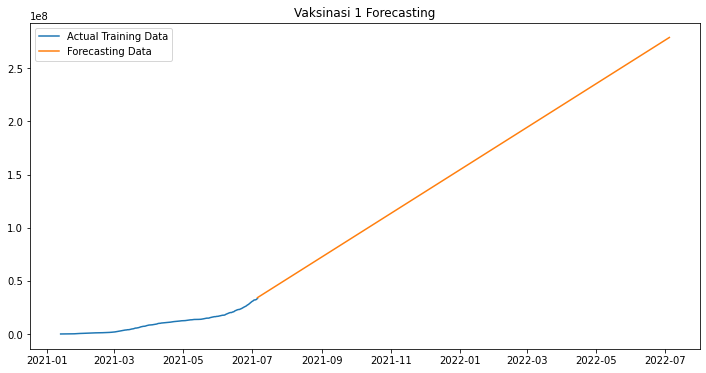

In [37]:
plot_forecasting('Vaksinasi 1 Forecasting', train_dosis_1, vaksinasi_1_forecasting,  'Actual Training Data', 'Forecasting Data')

In [38]:
date_target_achieved_1 = vaksinasi_1_forecasting.index[vaksinasi_1_forecasting.forecast_vaksinasi_1 >= 208e6].tolist()[0]

print('The 1st dose of vaccination target is reached by date:', date_target_achieved_1.date())

The 1st dose of vaccination target is reached by date: 2022-03-22


### 2nd Dose of Vaccination

In [39]:
vaksinasi_2_forecasting = create_forecasting_df(train_dosis_2.index[-1], model_arima_2, 
                                                3650, ['forecast_vaksinasi_2'])
vaksinasi_2_forecasting.head(3)

,forecast_vaksinasi_2
2021-07-06,1.451702e+07
2021-07-07,1.464789e+07
2021-07-08,1.477876e+07


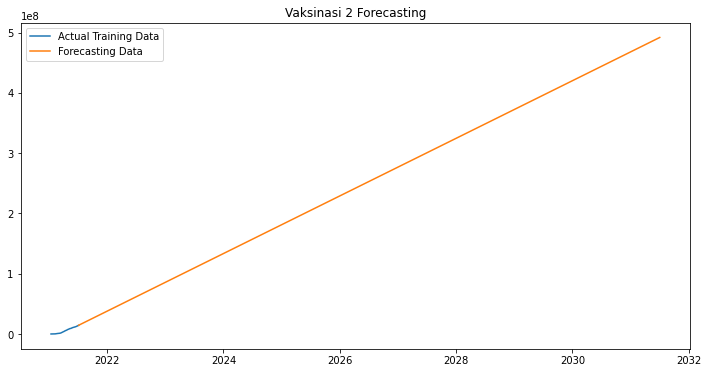

In [40]:
plot_forecasting('Vaksinasi 2 Forecasting', train_dosis_2, vaksinasi_2_forecasting,  'Actual Training Data', 'Forecasting Data')

In [41]:
date_target_achieved_2 = vaksinasi_2_forecasting.index[vaksinasi_2_forecasting.forecast_vaksinasi_2 >= 208e6].tolist()[0]

print('The 2nd dose of vaccination target is reached by date:', date_target_achieved_2.date())

The 2nd dose of vaccination target is reached by date: 2025-07-24


## References

*   A. Sulasikin, Y. Nugraha, J. Kanggrawan and A. L. Suherman, "Forecasting for a data-driven policy using time series methods in handling COVID-19 pandemic in Jakarta," 2020 IEEE International Smart Cities Conference (ISC2), 2020, pp. 1-6, doi: 10.1109/ISC251055.2020.9239066
*   https://machinelearningmastery.com/time-series-data-stationary-python/
*   https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
*   https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q#Forecast-modeling---ARIMA
*   https://money.kompas.com/read/2021/08/18/161853026/berubah-jadi-endemi-pemerintah-kejar-target-vaksinasi-ke-208-juta-jiwa